# Social Distancing Detector 

Download these three files

    yolov3.cfg (configuration files) https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
    yolov3.weights (trained model to detect objects) https://pjreddie.com/media/files/yolov3.weights
    coco.names (Dataset of 80 objects) https://github.com/pjreddie/darknet/blob/master/data/coco.names

In [25]:
# import the necessary packages

import numpy as np
import cv2
import math
import time

In [26]:
cv2.__version__

'4.5.2'

In [27]:
# Load Yolo Model
net = cv2.dnn.readNet("../Unknown/yolov3.weights", "../Unknown/yolov3.cfg")

classes = []

# From the net, we are loading the layer names.In output_layers we get detection of every object.
with open("../Unknown/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
    
    
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Assign random colors in the classess; The '3' is the channel (for RGB).
np.random.uniform(0, 255, size=(len(classes),3))

array([[ 65.26087197, 241.32738635,  89.15472252],
       [137.35860237, 239.19884932,  23.40266016],
       [194.90995725,  81.0735026 , 110.09222552],
       [141.98992434,  18.1675455 , 162.76582047],
       [ 73.46196097, 250.52903746, 214.84414852],
       [131.96738945, 164.38335027,  13.39291096],
       [157.12569632, 172.56607974, 231.55113075],
       [203.21282783, 188.96895657,  67.06257501],
       [211.42977933,  66.29979662, 134.5701626 ],
       [190.55086971,  18.38007258,  57.96522109],
       [ 15.07751604, 130.06584561,  93.61490419],
       [ 28.23587272, 174.14177809,  98.21237292],
       [ 50.23614749, 185.12359015,  27.01179928],
       [ 48.18800159, 196.10563781, 227.93542359],
       [137.49252652,  94.0570267 , 232.00736002],
       [142.45321794,  75.66642345, 130.71282293],
       [221.72800973,  29.91128484,  55.6976196 ],
       [ 22.83559095,  80.9975287 ,  26.21322444],
       [213.02708451, 254.82612792,  99.94884781],
       [218.92213282,  79.39844

In [71]:
# Video capture from : https://www.youtube.com/watch?v=QbZZQa4s9NM
cap = cv2.VideoCapture('../Unknown/test_folder/social.mp4')
# Start live camera
#cap = cv2.VideoCapture(0)
# If you want to use CCTV or IP Webcam put the URL under single codes
#cap = cv2.VideoCapture('http://192.168.43.1:8080//video')

In [72]:
# Euclidean distence for each video

def E_dist(p1, p2):
    return ((p1[0] - p2[0]) ** 2 +  (p1[1] - p2[1]) ** 2) ** 0.5

#  the function that calculates the Euclidean distance between two points. 
#  The distance equals to the root of the sum of the squared point and we returned our distance.
def isclose(p1, p2):
    c_d = E_dist(p1, p2)
    calib = (p1[1] + p2[1]) / 2
    if 0 < c_d < 0.15 * calib:
        return 1
    elif 0 < c_d < 0.2 * calib:
         return 2
    else:
        return 0
height,width=(None,None)
q=0

In [73]:
# Start capture frame-by-frame
while(cap.isOpened()):
    ret, img = cap.read()    
    print(ret)
    if not ret:
        break
    if width is None or height is None:
        height,width=img.shape[:2]
        q=width
        
    #height, width, channels = img.shape
    img =img[0:height, 0:q]
    height,width=img.shape[:2]
       
    
    # Detecting objects 0.00392
    blob = cv2.dnn.blobFromImage(img,0.00392, (416, 416), (0,0,0), True, crop=False)
    net.setInput(blob)
    start = time.time()
    outs = net.forward(output_layers)
    end=time.time()
    
    # Showing informations on the screen

    class_ids = []

    confidences = []

    boxes = []

    for out in outs:

        for detection in out:

            scores = detection[5:]

            class_id = np.argmax(scores)

            confidence = scores[class_id]

            if classes[class_id]=="person":

                # 0.5 is the threshold for confidence

                if confidence > 0.5:

                    # Object detected

                    #Purpose : Converts center coordinates to rectangle coordinates

                    # x, y = midpoint of box

                    center_x = int(detection[0] * width)

                    center_y = int(detection[1] * height)           

                    # w, h = width, height of the box

                    w = int(detection[2] * width)

                    h = int(detection[3] * height)

                    # Rectangle coordinates

                    x = int(center_x - w / 2)

                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])

                    confidences.append(float(confidence))

                    class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)

    #print(indexes)

    font = cv2.FONT_HERSHEY_SIMPLEX  

    if len(indexes)>0:       

        status=list()       

        idf = indexes.flatten()     

        close_pair = list()   

        s_close_pair = list()        

        center = list()        

        dist = list()        

        for i in idf:            

            (x, y) = (boxes[i][0], boxes[i][1])          

            (w, h) = (boxes[i][2], boxes[i][3])           

            center.append([int(x + w / 2), int(y + h / 2)])            

            status.append(0)            

        for i in range(len(center)):           

            for j in range(len(center)):               

                #compare the closeness of two values

                g=isclose(center[i], center[j])                

                if g ==1:                    

                    close_pair.append([center[i],center[j]])                

                    status[i] = 1               

                    status[j] = 1                 

                elif g == 2:               

                    s_close_pair.append([center[i], center[j]])                 

                    if status[i] != 1:                 

                        status[i] = 2               

                    if status[j] != 1:                        

                        status[j] = 2

        total_p = len(center)        

        low_risk_p = status.count(2)        

        high_risk_p = status.count(1)        

        safe_p = status.count(0)        

        kk = 0        

        for i in idf:            

            #sub_img = img[10:170, 10:width - 10]            

            #black_rect = np.ones(sub_img.shape, dtype=np.uint8)*0            

            #res = cv2.addWeighted(sub_img, 0.77, black_rect,0.23, 1.0)

            #img[10:170, 10:width - 10] = res   

            # adding text to image            

            #(image,text,org( X coordinate value, Y coordinate value),font,fontScale,color,thikness)        

            #image = cv2.rectangle(image, start_point, end_point, color, thickness)

            tot_str = "NUMBER OF PEOPLE: " + str(total_p)            

            high_str = "RED ZONE: " + str(high_risk_p)            

            low_str = "ORANGE ZONE: " + str(low_risk_p)            

            safe_str = "GREEN ZONE: " + str(safe_p)            

            #image ROI

            #sub_img = img[height - 120:height-20, 0:500]
            sub_img = img[height - 120:height-20, width//2:width//2 + 500]

            #cv2.imshow("sub_img",sub_img)            

            black_rect = np.ones(sub_img.shape, dtype=np.uint8) * 0
            
            res = cv2.addWeighted(sub_img, 0.9, black_rect, 0.1, 1.0)

            # put data on bottom left corner
            #img[height - 120:height-20, 0:500] = res
            # put data on center
            img[height - 120:height-20, width//2:width//2 + 500] = res
 
            cv2.putText(img, tot_str, (width//2 + 10, height - 75),font, 0.6, (255, 255, 255), 1)            

            cv2.putText(img, safe_str, (width//2 + 300, height - 75),font, 0.6, (0, 255, 0), 1)            

            cv2.putText(img, low_str, (width//2 + 10, height - 50),font, 0.6, (0, 120, 255), 1)            

            cv2.putText(img, high_str, (width//2 + 300, height - 50),font, 0.6, (0, 0, 150), 1)

            (x, y) = (boxes[i][0], boxes[i][1])            

            (w, h) = (boxes[i][2], boxes[i][3])        

            #color of the ractangle when is too close 

            if status[kk] == 1:                

                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 150), 2) # Red

            elif status[kk] == 0:                

                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green

            else:

                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 120, 255), 2) # Orange

            kk += 1

        for h in close_pair:            

            cv2.line(img, tuple(h[0]), tuple(h[1]), (0, 0, 255), 2)         

        for b in s_close_pair:

            cv2.line(img, tuple(b[0]), tuple(b[1]), (0, 255, 255), 2)

    cv2.imshow('image',img)

    if cv2.waitKey(1) & 0xFF == ord('q'):

        break

    cv2.waitKey(1)

    #FourCC code is passed as

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')

    output = cv2.VideoWriter('../Unknown/test_folder/output.mp4',fourcc, 20.0, (img.shape[1], img.shape[0]))

    #cv2.imwrite("output1.mp4",img)

    #img = cv2.flip(img,0)

    output.write(img)

cap.release()

output.release()

cv2.destroyAllWindows()

# press 'q' to release the window.

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


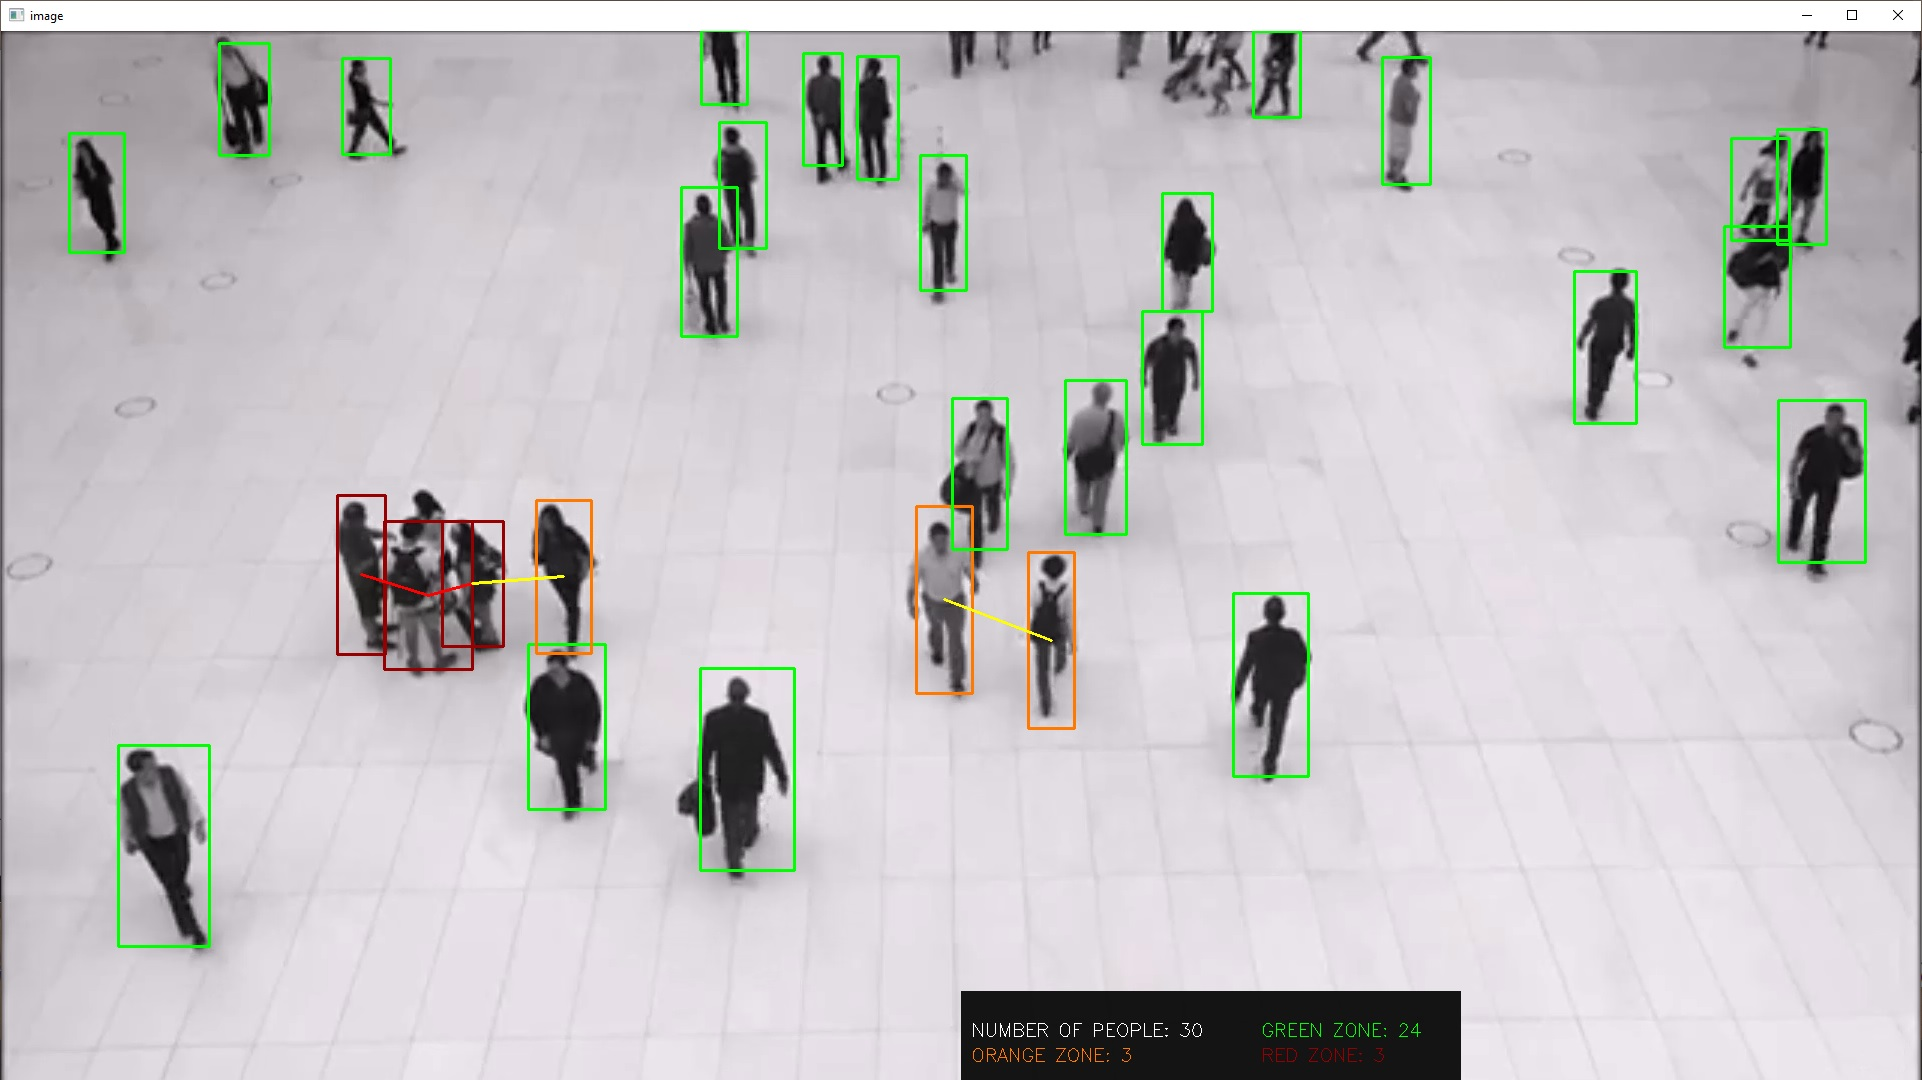

In [75]:
from IPython.display import Image
Image(filename='../Unknown/test_folder/result7.jpg') 

#### Reference:
    https://www.goeduhub.com/10498/social-distancing-detection-python-machine-learning-learning